In [1]:
#

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
12,application_1685607180068_0013,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('fsspec')
sc.install_pypi_package('s3fs ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load the data

In [4]:
s3_uri = 's3a://noaa-swdi-pds/hail-????.csv'

schema = StructType([
    StructField("ZTIME", StringType(), nullable=True),
    StructField("LON", DoubleType(), nullable=True),
    StructField("LAT", DoubleType(), nullable=True),
    StructField("WSR_ID", StringType(), nullable=True),
    StructField("CELL_ID", StringType(), nullable=True),
    StructField("RANGE", DoubleType(), nullable=True),
    StructField("AZIMUTH", DoubleType(), nullable=True),
    StructField("SEVPROP", DoubleType(), nullable=True),
    StructField("PROB", DoubleType(), nullable=True)
])

hail = (
    spark
    .read
    .option("comment", "#")
    .csv(s3_uri, header=True, schema=schema)
    .where(F.col('LON').isNotNull())
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
s3_uri = 's3a://noaa-swdi-pds/structure-????.csv'

schema = StructType([
    StructField("ZTIME", StringType(), nullable=True),
    StructField("LON", DoubleType(), nullable=True),
    StructField("LAT", DoubleType(), nullable=True),
    StructField("WSR_ID", StringType(), nullable=True),
    StructField("CELL_ID", StringType(), nullable=True),
    StructField("RANGE", DoubleType(), nullable=True),
    StructField("AZIMUTH", DoubleType(), nullable=True),
    StructField("BASE_HEIGHT", DoubleType(), nullable=True),
    StructField("TOP_HEIGHT", DoubleType(), nullable=True),
    StructField("VIL", DoubleType(), nullable=True),
    StructField("MAX_REFLECT", DoubleType(), nullable=True),
    StructField("HEIGHT", DoubleType(), nullable=True)
])

structure = (
    spark
    .read
    .option("comment", "#")
    .csv(s3_uri, header=True, schema=schema)
    .where(F.col('LON').isNotNull())
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
hail = (
    hail
    .withColumn('ZTIME', F.to_timestamp(F.col('ZTIME'), 'yyyyMMddHHmmss'))
    .withColumn('ZDAY', F.date_format(F.col('ZTIME'), 'yyyy-MM-dd'))
    .withColumn('ZYEAR', F.year('ZTIME'))
    .withColumn('ZMONTH', F.month('ZTIME'))
    .withColumn('ZDAY', F.dayofyear('ZTIME'))
    .withColumn('ZHOUR', F.hour('ZTIME'))
    .withColumnRenamed('RANGE', 'RANGE_HAIL')
    .withColumnRenamed('AZIMUTH', 'AZIMUTH_HAIL')
    .withColumnRenamed('LON', 'LON_HAIL')
    .withColumnRenamed('LAT', 'LAT_HAIL')
    .withColumnRenamed('SEVPROP', 'SEVPROB')
)

structure = (
    structure
    .withColumn('ZTIME', F.to_timestamp(F.col('ZTIME'), 'yyyyMMddHHmmss'))
    .withColumn('ZDAY', F.date_format(F.col('ZTIME'), 'yyyy-MM-dd'))
    .withColumn('ZYEAR', F.year('ZTIME'))
    .withColumn('ZMONTH', F.month('ZTIME'))
    .withColumn('ZDAY', F.dayofyear('ZTIME'))
    .withColumn('ZHOUR', F.hour('ZTIME'))
    .withColumnRenamed('RANGE', 'RANGE_STRUCTURE')
    .withColumnRenamed('AZIMUTH', 'AZIMUTH_STRUCTURE')
    .withColumnRenamed('LON', 'LON_STRUCTURE')
    .withColumnRenamed('LAT', 'LAT_STRUCTURE')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
merge_cols = ['WSR_ID', 'CELL_ID', 'ZYEAR', 'ZMONTH', 'ZDAY', 'ZHOUR']

merged_df = (
    hail
    .join(structure, on=merge_cols, how='inner')
    .filter(
        (F.col('SEVPROB') >= 0) &
        (F.col('PROB') >= 0) &
        (F.col('RANGE_HAIL') >= 0) &
        (F.col('RANGE_STRUCTURE') >= 0) &
        (F.col('AZIMUTH_HAIL') >= 0) &
        (F.col('AZIMUTH_STRUCTURE') >= 0) &
        (F.col('BASE_HEIGHT') >= 0) &
        (F.col('TOP_HEIGHT') >= 0) &
        (F.col('VIL') >= 0) &
        (F.col('MAX_REFLECT') >= 0) &
        (F.col('HEIGHT') >= 0) &
        (F.col('TOP_HEIGHT') >= 0)
    )
    .filter(F.col('ZYEAR') >= 2022)
    .withColumn('LON', (F.col('LON_HAIL') + F.col('LON_STRUCTURE'))/2)
    .withColumn('LAT', (F.col('LAT_HAIL') + F.col('LAT_STRUCTURE'))/2)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Scatter Plot `HEIGHT` vs `SEVPROB`

In [10]:
from pyspark.sql.window import Window

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
merged_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[WSR_ID: string, CELL_ID: string, ZYEAR: int, ZMONTH: int, ZDAY: int, ZHOUR: int, ZTIME: timestamp, LON_HAIL: double, LAT_HAIL: double, RANGE_HAIL: double, AZIMUTH_HAIL: double, SEVPROB: double, PROB: double, ZTIME: timestamp, LON_STRUCTURE: double, LAT_STRUCTURE: double, RANGE_STRUCTURE: double, AZIMUTH_STRUCTURE: double, BASE_HEIGHT: double, TOP_HEIGHT: double, VIL: double, MAX_REFLECT: double, HEIGHT: double, LON: double, LAT: double]

In [13]:
window = Window.partitionBy('ZMONTH').orderBy('ZDAY')

# Add a row number column within each partition
df_with_row_number = merged_df.withColumn('row_number', F.row_number().over(window))

# Sample 100 datapoints per 'ZMONTH' using the row number
sampled_df = df_with_row_number.filter(F.col('row_number') <= 10_000).drop('row_number')

# Show the sampled DataFrame
sampled_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[WSR_ID: string, CELL_ID: string, ZYEAR: int, ZMONTH: int, ZDAY: int, ZHOUR: int, ZTIME: timestamp, LON_HAIL: double, LAT_HAIL: double, RANGE_HAIL: double, AZIMUTH_HAIL: double, SEVPROB: double, PROB: double, ZTIME: timestamp, LON_STRUCTURE: double, LAT_STRUCTURE: double, RANGE_STRUCTURE: double, AZIMUTH_STRUCTURE: double, BASE_HEIGHT: double, TOP_HEIGHT: double, VIL: double, MAX_REFLECT: double, HEIGHT: double, LON: double, LAT: double]

In [14]:
pdf = sampled_df.select('HEIGHT', 'SEVPROB').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
sc.install_pypi_package('seaborn')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
merged_df.select('SEVPROB').distinct().show(30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
|SEVPROB|
+-------+
|   20.0|
|   70.0|
|   80.0|
|   60.0|
|   40.0|
|  100.0|
|   10.0|
|   30.0|
|   90.0|
|    0.0|
|   50.0|
+-------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

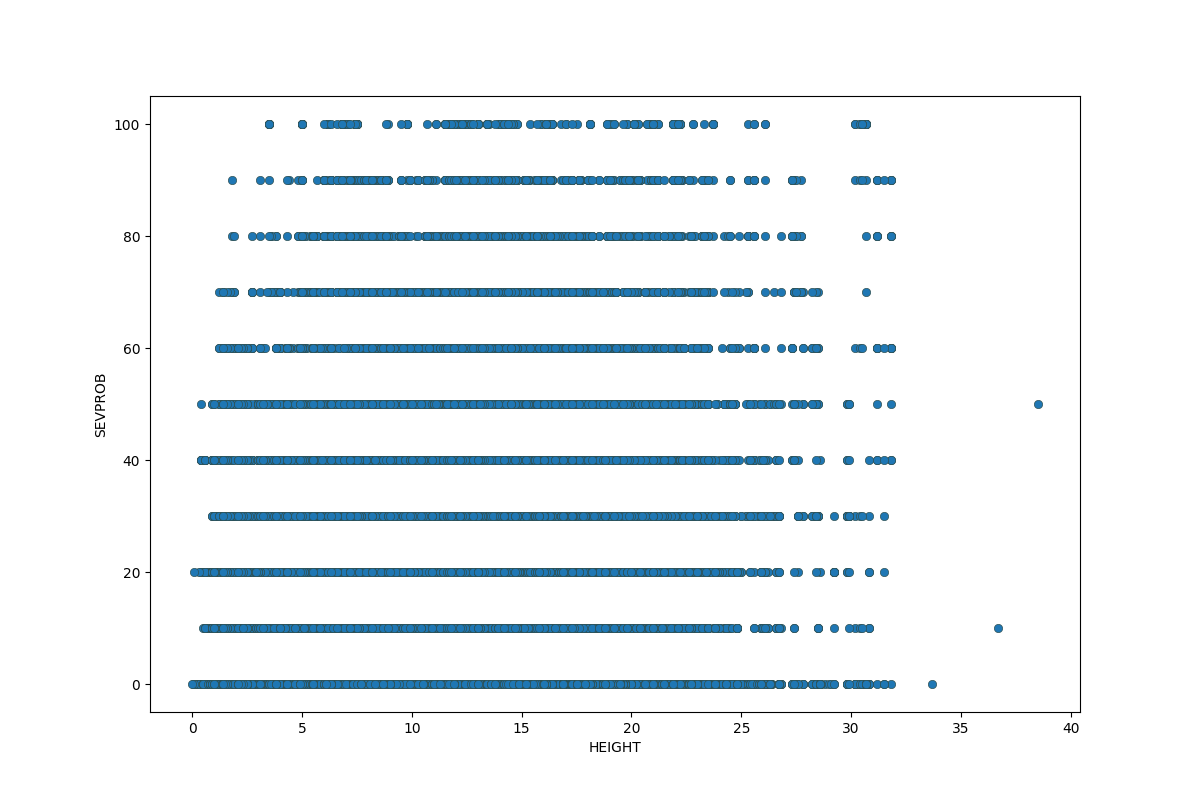

In [20]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x=pdf['HEIGHT'], y=pdf['SEVPROB'], ec='darkslategray',
                palette='colorblind')

%matplot plt

## Average `BASE_HEIGHT`, `TOP_HEIGHT`, and `HEIGHT` on `structure` data

In [8]:
means = tuple(structure.select(
    F.avg('BASE_HEIGHT'),
    F.avg('TOP_HEIGHT'),
    F.avg('HEIGHT')
).first())
means

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(9.657629776985058, 18.247489824780814, 11.636777251007867)